In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
!pip install catboost

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.7/98.7 MB 7.7 MB/s eta 0:00:00


In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.ensemble import AdaBoostClassifier, RandomForestClassifier
from sklearn.preprocessing import StandardScaler
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix, roc_curve, auc
from xgboost import XGBClassifier
from imblearn.over_sampling import SMOTE
from catboost import CatBoostClassifier

In [4]:
data1 = pd.read_csv('/content/drive/MyDrive/Projects/Voice_Call_Rating/Dataset/MyCall_Data_November_2019.csv')
data2 = pd.read_csv('/content/drive/MyDrive/Projects/Voice_Call_Rating/Dataset/MyCall_Data_October_2019.csv')
data3 = pd.read_csv('/content/drive/MyDrive/Projects/Voice_Call_Rating/Dataset/MyCall_Data_September_2019.csv')

dataset = pd.concat([data1, data2, data3])

In [5]:
dataset

,Operator,In Out Travelling,Network Type,Rating,Call Drop Category,Latitude,Longitude,State Name
0,RJio,Travelling,4G,2,Poor Voice Quality,26.483777,80.319767,Uttar Pradesh
1,RJio,Outdoor,4G,5,Satisfactory,21.258587,81.567728,Chhattisgarh
2,RJio,Indoor,4G,2,Poor Voice Quality,-1.000000,-1.000000,NaN
3,BSNL,Indoor,4G,5,Satisfactory,-1.000000,-1.000000,NaN
4,BSNL,Outdoor,Unknown,4,Satisfactory,20.278975,85.836103,Odisha
...,...,...,...,...,...,...,...,...
24611,BSNL,Travelling,Unknown,4,Satisfactory,17.339183,74.140695,Maharashtra
24612,Vodafone,Indoor,3G,4,Satisfactory,-1.000000,-1.000000,NaN
24613,Vodafone,Indoor,3G,4,Satisfactory,-1.000000,-1.000000,NaN
24614,Vodafone,Indoor,3G,5,Satisfactory,19.386358,72.823430,Maharashtra


In [6]:
dataset.isnull().sum()

,0
Operator,0
In Out Travelling,0
Network Type,0
Rating,0
Call Drop Category,0
Latitude,0
Longitude,0
State Name,20795


In [7]:
dataset.dropna(inplace=True)

In [8]:
dataset.reset_index(drop=True, inplace=True)
dataset

,Operator,In Out Travelling,Network Type,Rating,Call Drop Category,Latitude,Longitude,State Name
0,RJio,Travelling,4G,2,Poor Voice Quality,26.483777,80.319767,Uttar Pradesh
1,RJio,Outdoor,4G,5,Satisfactory,21.258587,81.567728,Chhattisgarh
2,BSNL,Outdoor,Unknown,4,Satisfactory,20.278975,85.836103,Odisha
3,RJio,Outdoor,4G,4,Satisfactory,25.583645,85.241034,Bihar
4,Idea,Indoor,4G,4,Satisfactory,30.583200,76.843046,Punjab
...,...,...,...,...,...,...,...,...
78690,Vodafone,Outdoor,4G,2,Poor Voice Quality,23.064292,72.629689,Gujarat
78691,RJio,Indoor,4G,1,Call Dropped,20.251703,85.779347,Odisha
78692,BSNL,Travelling,2G,1,Call Dropped,17.339183,74.140695,Maharashtra
78693,BSNL,Travelling,Unknown,4,Satisfactory,17.339183,74.140695,Maharashtra


In [9]:
Label = dataset['Rating']
dataset = dataset.drop(columns = ['Rating'])

In [10]:
Label.value_counts()

,count
Rating,
5,25855
1,19584
4,18704
3,8960
2,5592


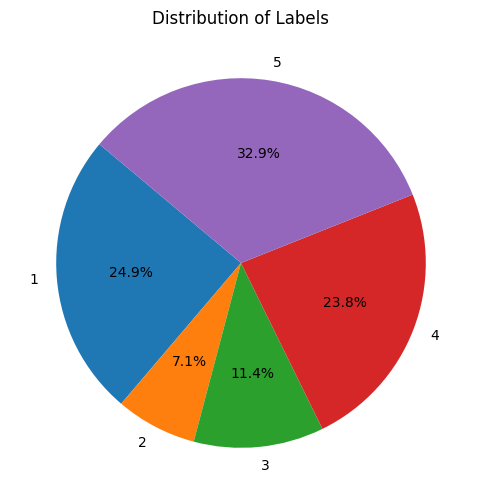

In [11]:
plt.figure(figsize=(6, 6))
plt.pie(np.unique(Label, return_counts=True)[1], labels=np.unique(Label, return_counts=True)[0], autopct='%1.1f%%', startangle=140)
plt.title('Distribution of Labels')
plt.show()

In [12]:
dataset

,Operator,In Out Travelling,Network Type,Call Drop Category,Latitude,Longitude,State Name
0,RJio,Travelling,4G,Poor Voice Quality,26.483777,80.319767,Uttar Pradesh
1,RJio,Outdoor,4G,Satisfactory,21.258587,81.567728,Chhattisgarh
2,BSNL,Outdoor,Unknown,Satisfactory,20.278975,85.836103,Odisha
3,RJio,Outdoor,4G,Satisfactory,25.583645,85.241034,Bihar
4,Idea,Indoor,4G,Satisfactory,30.583200,76.843046,Punjab
...,...,...,...,...,...,...,...
78690,Vodafone,Outdoor,4G,Poor Voice Quality,23.064292,72.629689,Gujarat
78691,RJio,Indoor,4G,Call Dropped,20.251703,85.779347,Odisha
78692,BSNL,Travelling,2G,Call Dropped,17.339183,74.140695,Maharashtra
78693,BSNL,Travelling,Unknown,Satisfactory,17.339183,74.140695,Maharashtra


In [13]:
dataset.dtypes

,0
Operator,object
In Out Travelling,object
Network Type,object
Call Drop Category,object
Latitude,float64
Longitude,float64
State Name,object


In [14]:
object_columns = ["Operator", "In Out Travelling", "Network Type", "Call Drop Category", "State Name"]
OHE_columns = ["Operator", "In Out Travelling", "Network Type", "Call Drop Category"]

In [15]:
def Plot_Bar_Chart(dataset, column_name):
  figure_size = (20, 6)
  plt.figure(figsize=figure_size)

  column_name_counts = dataset[column_name].value_counts()

  # Create a bar chart
  bars = plt.bar(column_name_counts.index, column_name_counts.values, color='skyblue')

  plt.xlabel(column_name)
  plt.ylabel('Count')
  plt.title(f'Distribution of {column_name}')
  plt.xticks(rotation=90)

  # Add count values on top of each bar
  for bar in bars:
      height = bar.get_height()
      plt.text(bar.get_x() + bar.get_width() / 2, height, f'{int(height)}', ha='center', va='bottom')

  plt.show()

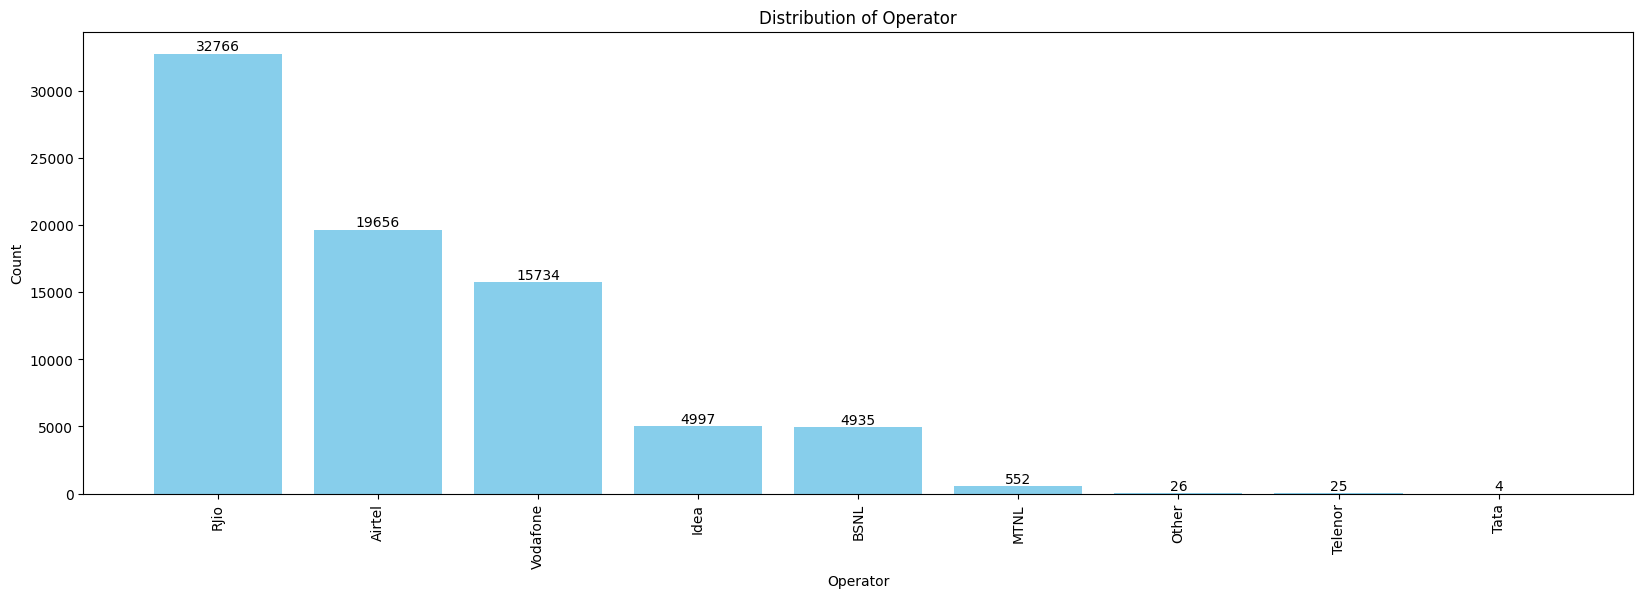

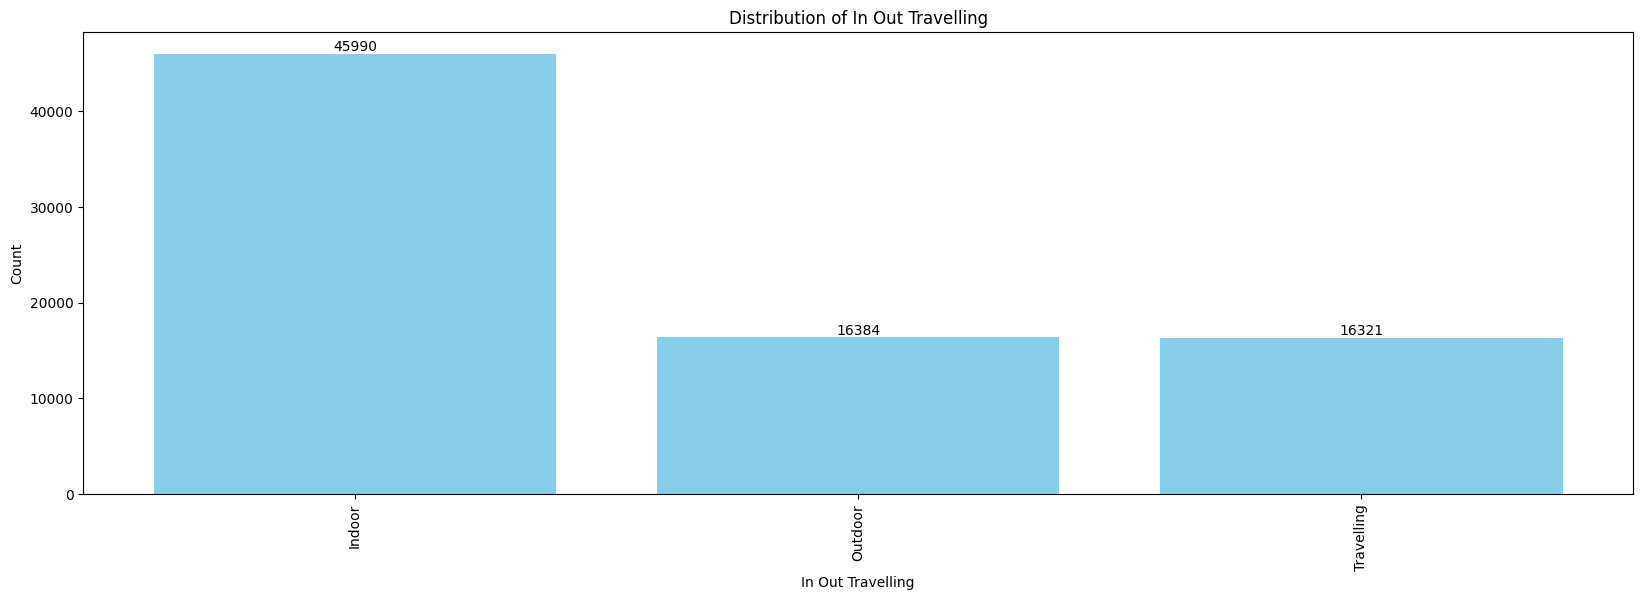

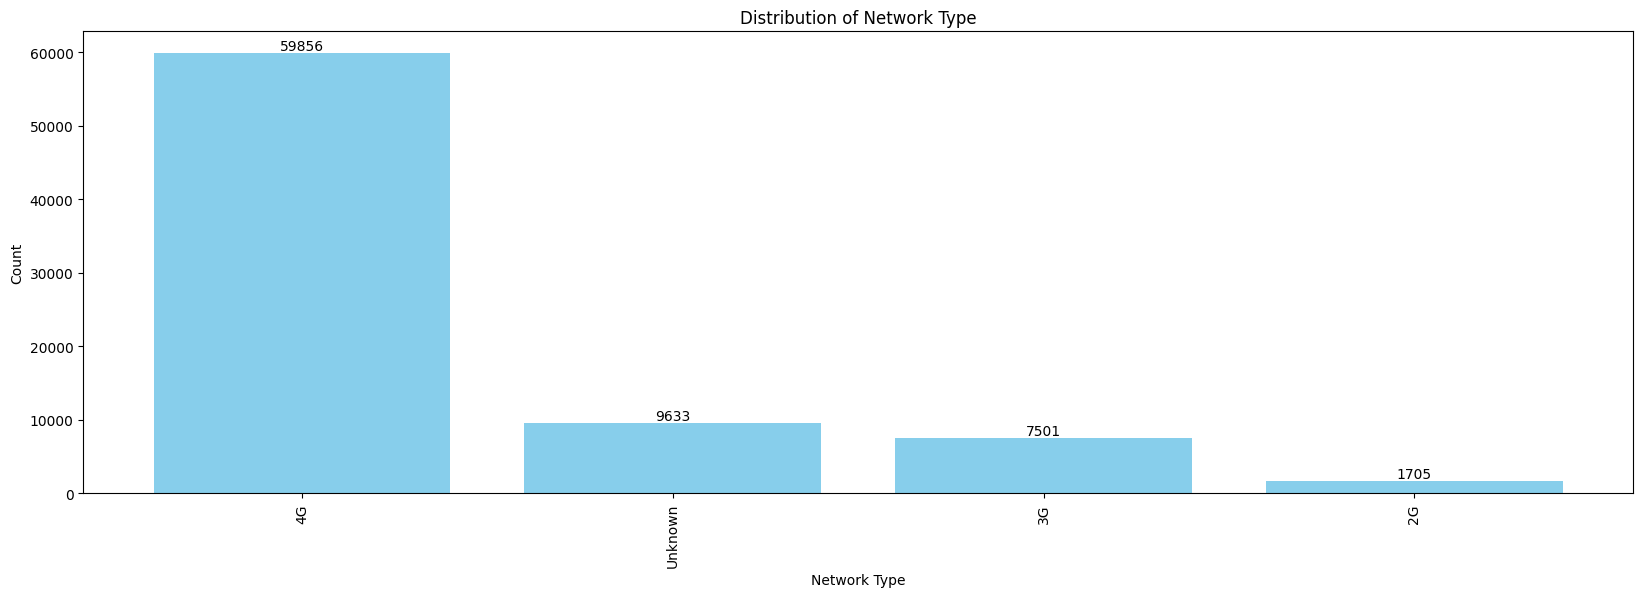

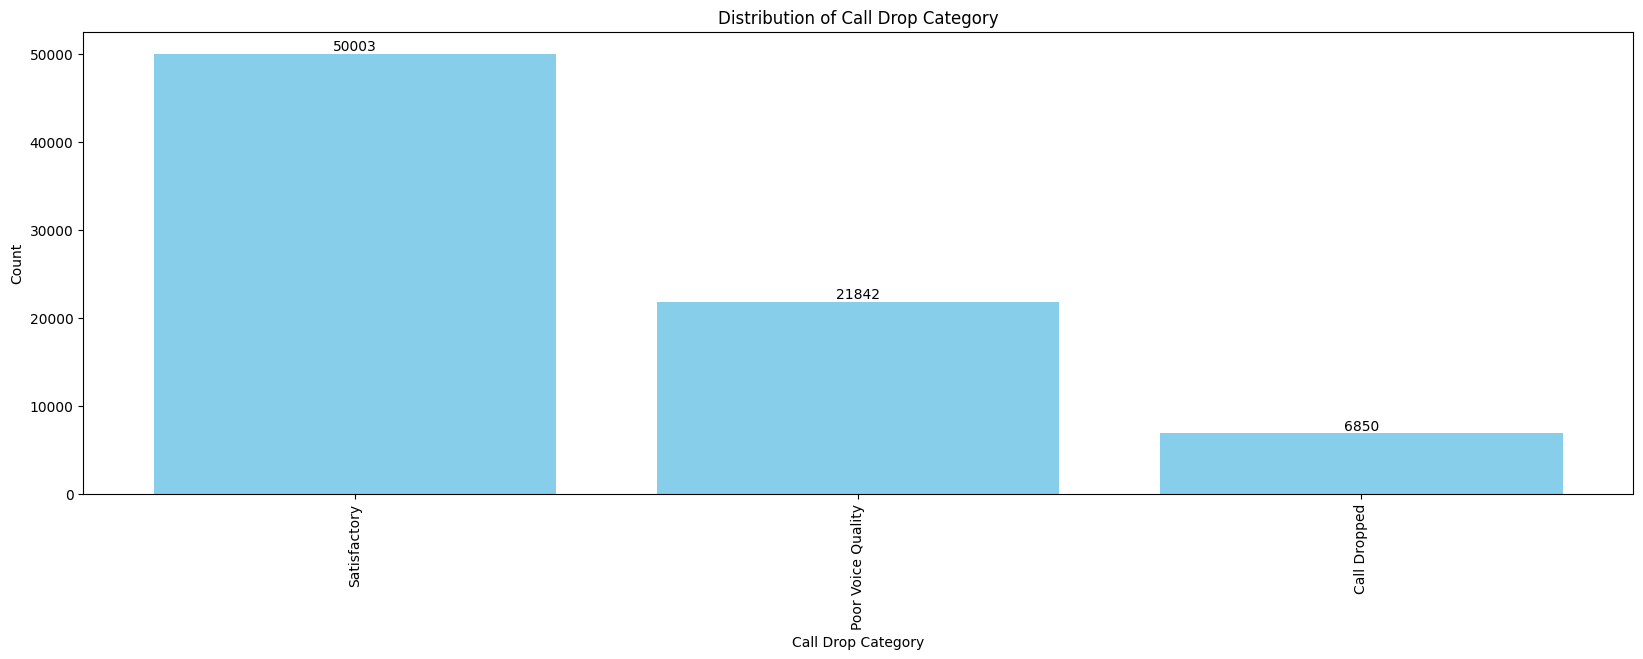

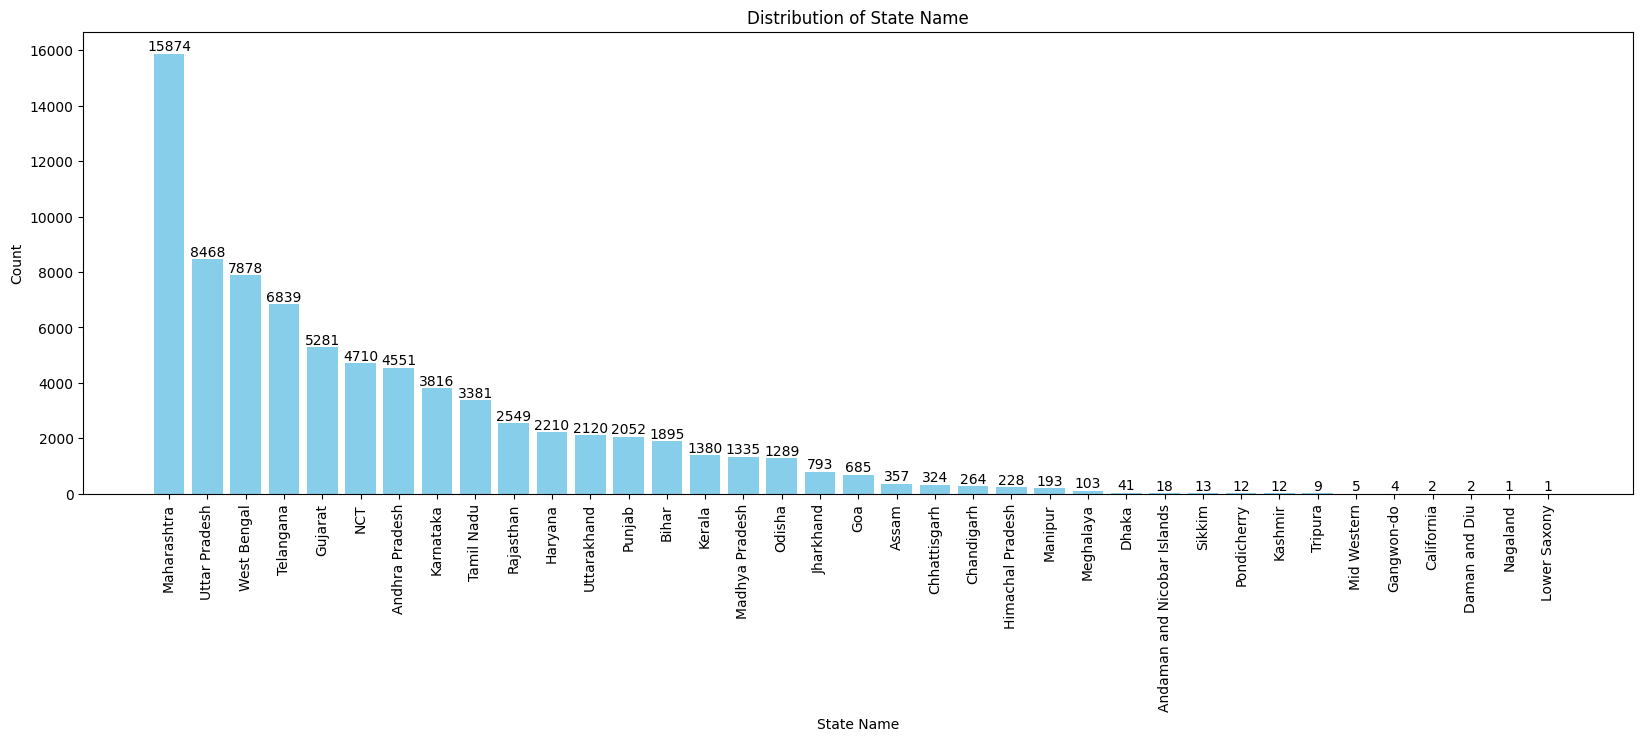

In [16]:
for name in object_columns:
  Plot_Bar_Chart(dataset, name)

In [17]:
def Preprocessing_OHE(dataset, object_columns):
  for column_name in object_columns:
    # Perform one-hot encoding
    one_hot_encoded = pd.get_dummies(dataset[column_name], dtype = int, drop_first = True)
    dataset = pd.concat([dataset, one_hot_encoded], axis=1)
    dataset.drop(columns=[column_name], inplace=True)
  return dataset

dataset_OHE = Preprocessing_OHE(dataset.copy(), OHE_columns)

In [18]:
dataset_OHE

,Latitude,Longitude,State Name,BSNL,Idea,MTNL,Other,RJio,Tata,Telenor,Vodafone,Outdoor,Travelling,3G,4G,Unknown,Poor Voice Quality,Satisfactory
0,26.483777,80.319767,Uttar Pradesh,0,0,0,0,1,0,0,0,0,1,0,1,0,1,0
1,21.258587,81.567728,Chhattisgarh,0,0,0,0,1,0,0,0,1,0,0,1,0,0,1
2,20.278975,85.836103,Odisha,1,0,0,0,0,0,0,0,1,0,0,0,1,0,1
3,25.583645,85.241034,Bihar,0,0,0,0,1,0,0,0,1,0,0,1,0,0,1
4,30.583200,76.843046,Punjab,0,1,0,0,0,0,0,0,0,0,0,1,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
78690,23.064292,72.629689,Gujarat,0,0,0,0,0,0,0,1,1,0,0,1,0,1,0
78691,20.251703,85.779347,Odisha,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0
78692,17.339183,74.140695,Maharashtra,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0
78693,17.339183,74.140695,Maharashtra,1,0,0,0,0,0,0,0,0,1,0,0,1,0,1


In [19]:
def Preprocessing_frequency(dataset, object_columns):
  for column_name in object_columns:
    # Calculate the frequency encoding
    frequency_encoding = dataset[column_name].value_counts().to_dict()
    dataset[f'{column_name}_Encoded'] = dataset[column_name].map(frequency_encoding)
    dataset.drop(columns=[column_name], inplace=True)
  return dataset

dataset_Encoded = Preprocessing_frequency(dataset_OHE.copy(), ["State Name"])

In [20]:
dataset_Encoded

,Latitude,Longitude,BSNL,Idea,MTNL,Other,RJio,Tata,Telenor,Vodafone,Outdoor,Travelling,3G,4G,Unknown,Poor Voice Quality,Satisfactory,State Name_Encoded
0,26.483777,80.319767,0,0,0,0,1,0,0,0,0,1,0,1,0,1,0,8468
1,21.258587,81.567728,0,0,0,0,1,0,0,0,1,0,0,1,0,0,1,324
2,20.278975,85.836103,1,0,0,0,0,0,0,0,1,0,0,0,1,0,1,1289
3,25.583645,85.241034,0,0,0,0,1,0,0,0,1,0,0,1,0,0,1,1895
4,30.583200,76.843046,0,1,0,0,0,0,0,0,0,0,0,1,0,0,1,2052
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
78690,23.064292,72.629689,0,0,0,0,0,0,0,1,1,0,0,1,0,1,0,5281
78691,20.251703,85.779347,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,1289
78692,17.339183,74.140695,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,15874
78693,17.339183,74.140695,1,0,0,0,0,0,0,0,0,1,0,0,1,0,1,15874


In [21]:
Samples = dataset_Encoded.copy()

In [22]:
smote = SMOTE(sampling_strategy={1: 60000, 2: 60000, 3: 60000, 4: 60000, 5: 60000}, random_state=42)
Samples_SMOTE, Label_SMOTE = smote.fit_resample(Samples, Label)

In [23]:
Samples_SMOTE

,Latitude,Longitude,BSNL,Idea,MTNL,Other,RJio,Tata,Telenor,Vodafone,Outdoor,Travelling,3G,4G,Unknown,Poor Voice Quality,Satisfactory,State Name_Encoded
0,26.483777,80.319767,0,0,0,0,1,0,0,0,0,1,0,1,0,1,0,8468
1,21.258587,81.567728,0,0,0,0,1,0,0,0,1,0,0,1,0,0,1,324
2,20.278975,85.836103,1,0,0,0,0,0,0,0,1,0,0,0,1,0,1,1289
3,25.583645,85.241034,0,0,0,0,1,0,0,0,1,0,0,1,0,0,1,1895
4,30.583200,76.843046,0,1,0,0,0,0,0,0,0,0,0,1,0,0,1,2052
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
299995,28.683213,77.361018,0,0,0,0,0,0,0,1,1,0,0,1,0,0,1,8468
299996,12.913273,77.602665,0,0,0,0,0,0,0,1,0,1,0,1,0,0,1,3816
299997,9.242258,76.560257,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1380
299998,17.405418,78.437951,1,0,0,0,0,0,0,0,0,0,0,0,1,0,1,6839


In [24]:
scale_columns = ["Longitude", "Latitude", "State Name_Encoded"]
sc = StandardScaler()
Samples_SMOTE[scale_columns] = sc.fit_transform(Samples_SMOTE[scale_columns])

In [25]:
Samples_SMOTE

,Latitude,Longitude,BSNL,Idea,MTNL,Other,RJio,Tata,Telenor,Vodafone,Outdoor,Travelling,3G,4G,Unknown,Poor Voice Quality,Satisfactory,State Name_Encoded
0,0.837095,0.366695,0,0,0,0,1,0,0,0,0,1,0,1,0,1,0,0.347643
1,-0.122568,0.620568,0,0,0,0,1,0,0,0,1,0,0,1,0,0,1,-1.352887
2,-0.302485,1.488882,1,0,0,0,0,0,0,0,1,0,0,0,1,0,1,-1.151387
3,0.671776,1.367827,0,0,0,0,1,0,0,0,1,0,0,1,0,0,1,-1.024850
4,1.589999,-0.340573,0,1,0,0,0,0,0,0,0,0,0,1,0,0,1,-0.992067
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
299995,1.241046,-0.235202,0,0,0,0,0,0,0,1,1,0,0,1,0,0,1,0.347643
299996,-1.655277,-0.186044,0,0,0,0,0,0,0,1,0,1,0,1,0,0,1,-0.623730
299997,-2.329499,-0.398101,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,-1.132386
299998,-0.830245,-0.016122,1,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0.007495


In [26]:
Label_SMOTE

,Rating
0,2
1,5
2,4
3,4
4,4
...,...
299995,5
299996,5
299997,5
299998,5


In [27]:
X_train, X_test, y_train, y_test = train_test_split(Samples_SMOTE, Label_SMOTE, test_size = 0.2, random_state = 42)

In [28]:
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((240000, 18), (60000, 18), (240000,), (60000,))

# XGBoost

In [29]:
XGB = XGBClassifier(n_estimators = 200, random_state=42)
XGB.fit(X_train, y_train - 1)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=200, n_jobs=None,
              num_parallel_tree=None, objective='multi:softprob', ...)

In [30]:
pre_XGB = XGB.predict(X_test)
print(classification_report(y_test - 1, pre_XGB))

              precision    recall  f1-score   support

           0       0.84      0.83      0.84     12011
           1       0.80      0.84      0.82     12072
           2       0.85      0.79      0.82     11984
           3       0.87      0.87      0.87     11993
           4       0.89      0.90      0.89     11940

    accuracy                           0.85     60000
   macro avg       0.85      0.85      0.85     60000
weighted avg       0.85      0.85      0.85     60000



# CatBoost

In [31]:
model_Cat = CatBoostClassifier(iterations=1000, learning_rate=0.9, depth=10, random_state = 42)
model_Cat.fit(X_train, y_train)

0:	learn: 0.9279879	total: 613ms	remaining: 10m 12s
1:	learn: 0.7970993	total: 1.21s	remaining: 10m 5s
2:	learn: 0.7311399	total: 2.27s	remaining: 12m 35s
3:	learn: 0.7061627	total: 3.51s	remaining: 14m 35s
4:	learn: 0.6765391	total: 4.65s	remaining: 15m 25s
5:	learn: 0.6510521	total: 5.79s	remaining: 15m 58s
6:	learn: 0.6342712	total: 6.61s	remaining: 15m 37s
7:	learn: 0.6212481	total: 7.17s	remaining: 14m 49s
8:	learn: 0.6118229	total: 7.72s	remaining: 14m 9s
9:	learn: 0.6026982	total: 8.39s	remaining: 13m 50s
10:	learn: 0.5868361	total: 8.96s	remaining: 13m 25s
11:	learn: 0.5789059	total: 9.58s	remaining: 13m 8s
12:	learn: 0.5673076	total: 10.1s	remaining: 12m 50s
13:	learn: 0.5636653	total: 10.8s	remaining: 12m 38s
14:	learn: 0.5562096	total: 11.5s	remaining: 12m 35s
15:	learn: 0.5492520	total: 12.2s	remaining: 12m 28s
16:	learn: 0.5444641	total: 12.9s	remaining: 12m 26s
17:	learn: 0.5383908	total: 13.7s	remaining: 12m 28s
18:	learn: 0.5303921	total: 14.6s	remaining: 12m 32s
19:	le

In [32]:
pre_Cat = model_Cat.predict(X_test)
print(classification_report(y_test, pre_Cat))

              precision    recall  f1-score   support

           1       0.88      0.86      0.87     12011
           2       0.83      0.86      0.85     12072
           3       0.85      0.86      0.86     11984
           4       0.89      0.88      0.88     11993
           5       0.91      0.91      0.91     11940

    accuracy                           0.87     60000
   macro avg       0.87      0.87      0.87     60000
weighted avg       0.87      0.87      0.87     60000



# Adaboost

In [33]:
Ada_model = AdaBoostClassifier(estimator=RandomForestClassifier(n_estimators = 1, max_features = None), n_estimators = 100, learning_rate = 0.5, random_state=42)
Ada_model.fit(X_train, y_train)

/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


AdaBoostClassifier(estimator=RandomForestClassifier(max_features=None,
                                                    n_estimators=1),
                   learning_rate=0.5, n_estimators=100, random_state=42)

In [34]:
pre_Ada = Ada_model.predict(X_test)
print(classification_report(y_test, pre_Ada))

              precision    recall  f1-score   support

           1       0.92      0.91      0.91     12011
           2       0.90      0.91      0.91     12072
           3       0.91      0.90      0.90     11984
           4       0.92      0.92      0.92     11993
           5       0.94      0.94      0.94     11940

    accuracy                           0.92     60000
   macro avg       0.92      0.92      0.92     60000
weighted avg       0.92      0.92      0.92     60000



In [35]:
test_samples =  pd.concat([X_test, y_test], axis = 1)
R1_samples = test_samples[test_samples["Rating"] == 1]
R2_samples = test_samples[test_samples["Rating"] == 2]
R3_samples = test_samples[test_samples["Rating"] == 3]
R4_samples = test_samples[test_samples["Rating"] == 4]
R5_samples = test_samples[test_samples["Rating"] == 5]

In [36]:
Accuracy_each_class = []
pre_R1 = Ada_model.predict(R1_samples.drop(columns = ["Rating"]))
pre_R2 = Ada_model.predict(R2_samples.drop(columns = ["Rating"]))
pre_R3 = Ada_model.predict(R3_samples.drop(columns = ["Rating"]))
pre_R4 = Ada_model.predict(R4_samples.drop(columns = ["Rating"]))
pre_R5 = Ada_model.predict(R5_samples.drop(columns = ["Rating"]))

Accuracy_each_class.append(accuracy_score(R1_samples["Rating"], pre_R1))
Accuracy_each_class.append(accuracy_score(R2_samples["Rating"], pre_R2))
Accuracy_each_class.append(accuracy_score(R3_samples["Rating"], pre_R3))
Accuracy_each_class.append(accuracy_score(R4_samples["Rating"], pre_R4))
Accuracy_each_class.append(accuracy_score(R5_samples["Rating"], pre_R5))

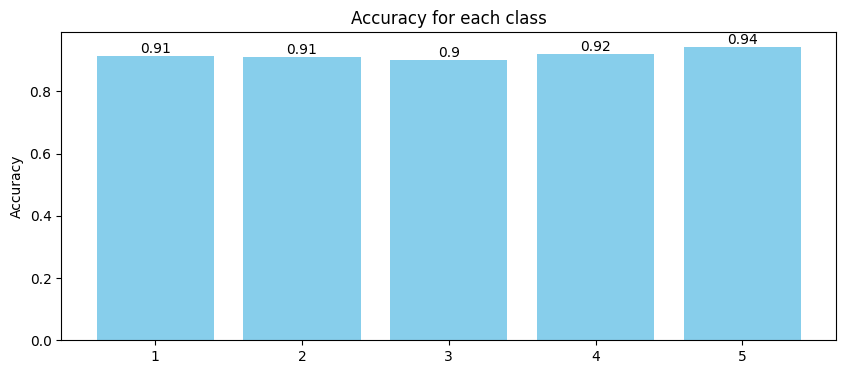

In [37]:
figure_size = (10, 4)
plt.figure(figsize=figure_size)
bars = plt.bar([1, 2, 3, 4, 5], Accuracy_each_class, color='skyblue')

plt.ylabel('Accuracy')
plt.title('Accuracy for each class')
plt.xticks(rotation=0)

for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width() / 2, height, f'{round(height, 2)}', ha='center', va='bottom')

plt.show()

In [38]:
out = classification_report(y_test, pre_Ada, output_dict = True)
P_R_F1 = pd.DataFrame(out).T[:5].drop(columns = ["support"])

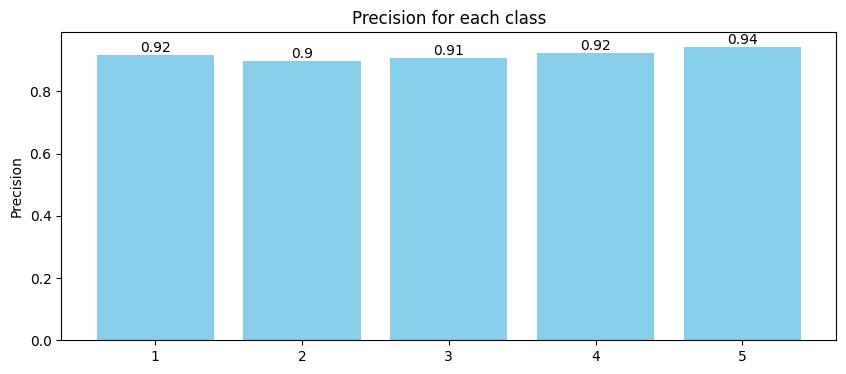

In [39]:
figure_size = (10, 4)
plt.figure(figsize=figure_size)
bars = plt.bar(P_R_F1.index, P_R_F1["precision"], color='skyblue')

plt.ylabel('Precision')
plt.title('Precision for each class')
plt.xticks(rotation=0)

for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width() / 2, height, f'{round(height, 2)}', ha='center', va='bottom')

plt.show()


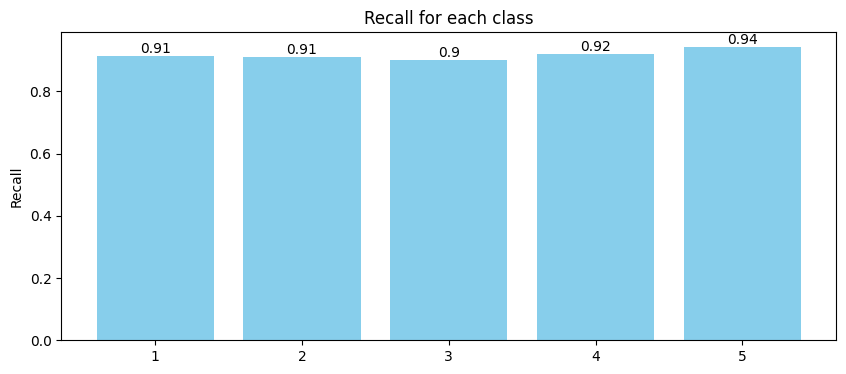

In [40]:
figure_size = (10, 4)
plt.figure(figsize=figure_size)
bars = plt.bar(P_R_F1.index, P_R_F1["recall"], color='skyblue')

plt.ylabel('Recall')
plt.title('Recall for each class')
plt.xticks(rotation=0)

for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width() / 2, height, f'{round(height, 2)}', ha='center', va='bottom')

plt.show()


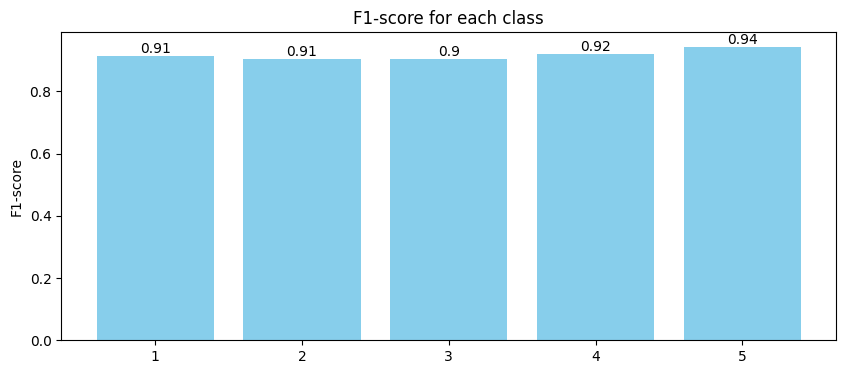

In [41]:
figure_size = (10, 4)
plt.figure(figsize=figure_size)
bars = plt.bar(P_R_F1.index, P_R_F1["f1-score"], color='skyblue')

plt.ylabel('F1-score')
plt.title('F1-score for each class')
plt.xticks(rotation=0)

for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width() / 2, height, f'{round(height, 2)}', ha='center', va='bottom')

plt.show()


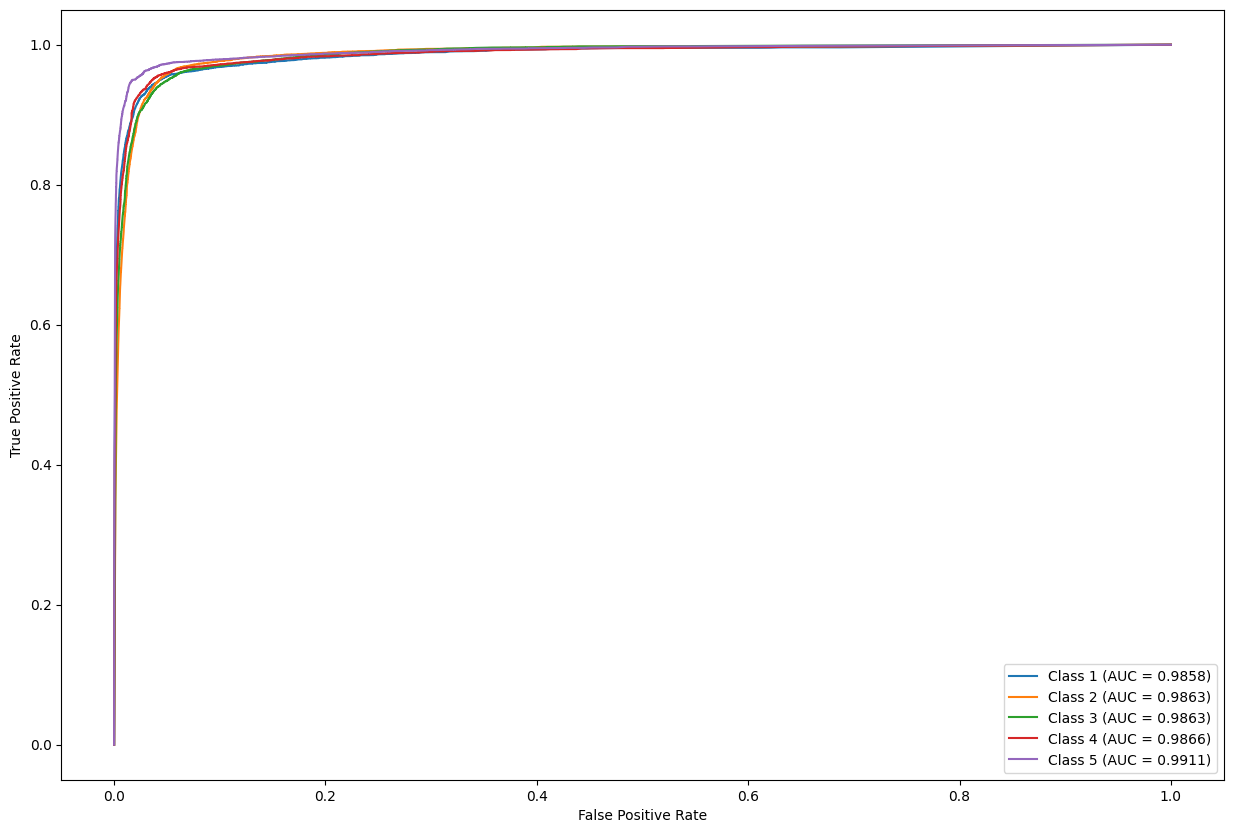

In [42]:
y_pred_pro = Ada_model.predict_proba(X_test)

all_fpr = []
all_tpr = []
all_auc = []

# Loop over each class
for i in range(0, 5):
    # Create binary labels for the current class
    y_test_class = (y_test == i + 1).astype(int)

    # Calculate ROC curve for the current class
    fpr, tpr, _ = roc_curve(y_test_class, y_pred_pro[:, i])

    # Calculate AUC for the current class
    roc_auc = auc(fpr, tpr)

    # Append fpr, tpr, and auc to lists
    all_fpr.append(fpr)
    all_tpr.append(tpr)
    all_auc.append(roc_auc)


plt.figure(figsize=(15, 10))  # Adjust width and height as needed

# Plot ROC curve for each class
for i in range(0, 5):
    plt.plot(all_fpr[i], all_tpr[i], label=f'Class {i + 1} (AUC = {all_auc[i]:.4f})')

# Axis labels and legend

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
plt.show()


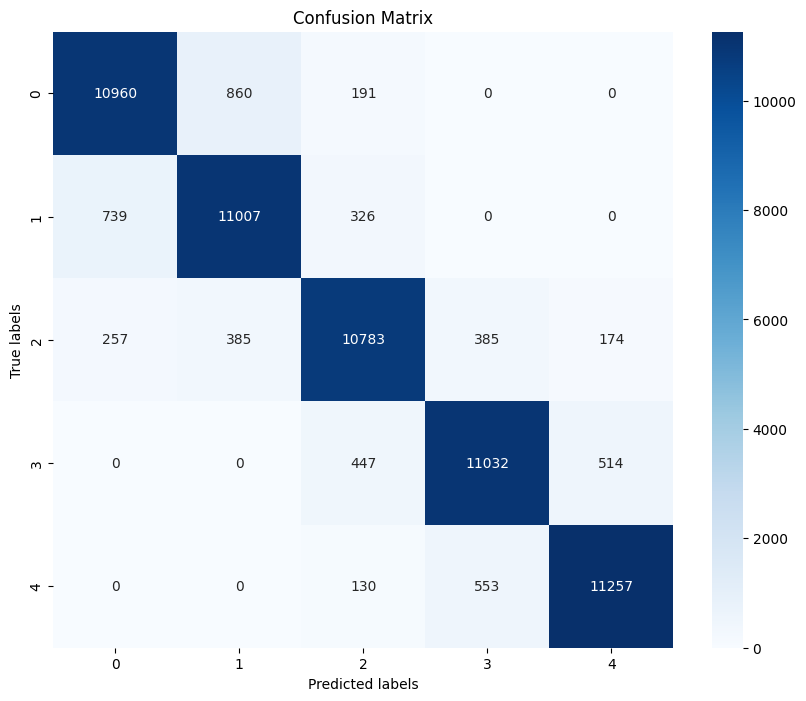

In [43]:
cm = confusion_matrix(y_test, pre_Ada)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='g', cmap='Blues')
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix')
plt.show()
